In [1]:
import cv2
import os
import json
import numpy as np
from numpy.random import choice
import pycocotools.mask as mask_utils
from pycocotools.coco import COCO
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Polygon

In [2]:
def bimask_to_polygon(mask):
    # input: mask image (RGB)
    # output: all the polygons on this mask
    
    # Using APPROX_NONE to prevent some special case where contour is unidentified (length==4) such as rectangle
    
    # latest version cv2 only return 2 objects (4.0)
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
    
    polygons = []
    for contour in contours:
        contour = contour.flatten().tolist()
        # contour(list) contains the least edge/contour coordinates which describe the mask
        # for more details about contour, 
        # you may refer to: https://docs.opencv.org/trunk/d4/d73/tutorial_py_contours_begin.html
        if len(contour)>4:
            polygons.append(contour)
    
    return polygons

In [3]:
def coco_dict_gen(files,imagesFile,masksFile):
    img_lst=[]
    anno_lst=[]
    
    # i should index started from 1 to avoid the computation mistake in coco eval as 0 has special meaning in computing ap
    for i,file in enumerate(tqdm(files)):
        file=files[i]
        
        # image dict
        image_dict={}
        # image file directory
        image_dir=imagesFile+file
        # load the image
        image=plt.imread(image_dir,'RGB')[:,:,:3]
        # specify the image dict
        image_dict['file_name']=image_dir
        image_dict['height']=int(image.shape[0])
        image_dict['width']=int(image.shape[1])
        image_dict['id']=i+1
        # append
        img_lst.append(image_dict)
        
        anno_dict={}
        # load mask
        mask_dir=masksFile+file
        mask=plt.imread(mask_dir,'RGB')[:,:,:3]
        # convert RGB mask into gray mask
        bimask=cv2.cvtColor(mask,cv2.COLOR_RGB2GRAY).astype(np.uint8)
        poly=bimask_to_polygon(bimask)
        bimask=np.asfortranarray(bimask,dtype=np.uint8) # convert to fortran format
        rle_cprs=mask_utils.encode(bimask)
        # save dict
        anno_dict['image_id']=i+1
        anno_dict['id']=i+1
        anno_dict['category_id']=1
        anno_dict['iscrowd']=0
        anno_dict['segmentation']=poly#rle_uncprs
        anno_dict['area']=float(mask_utils.area(rle_cprs))
        anno_dict['bbox']=list(mask_utils.toBbox(rle_cprs))
        # append
        anno_lst.append(anno_dict)
        
    data_dict={}
    data_dict['info']={}
    data_dict['licenses']=[]
    data_dict['images']=img_lst
    data_dict['annotations']=anno_lst
    data_dict['categories']=[{'supercategory': 'Slice', 'id': 1, 'name': 'Lesion Slice'}]
    
    return data_dict

In [4]:
def demo(data_dict,i):
    # this function is used to test the result
    color1=[1,1,1]
    color2=[1,0,0]
    img_lst=data_dict['images']
    anno_lst=data_dict['annotations']
    # load image
    img=plt.imread(img_lst[i]['file_name'])
    fig,ax=plt.subplots()
    ax.imshow(img)
    try:
        # load polygon
        polygon=Polygon(np.array(anno_lst[i]['segmentation'][0]).reshape(-1,2),facecolor=color1,linewidth=2,alpha=0.9)
        # bounding box
        bbox=anno_lst[i]['bbox']
        rect=Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],fill=False,linewidth=2,edgecolor=color2)
        # plot
        ax.add_patch(polygon)
        ax.add_patch(rect)
        ax.set_title('The area is: {}'.format(anno_lst[i]['area']))
    except:
        ax.set_title('No Mask')
    plt.show()

In [5]:
imgFile='./data/images/'
mskFile='./data/masks/'
# list all the files
all_img_files=os.listdir(imgFile)
all_msk_files=os.listdir(mskFile)
print('all images:',len(all_img_files))
print('all masks:',len(all_msk_files))

all images: 18574
all masks: 18574


In [6]:
f=open('./data/imgs_no_msk.txt','r')
nmskfiles=[]
for item in f.readlines():
    nmskfiles.append(item.strip('\n'))
f.close()

In [7]:
all_files=[file for file in all_img_files if file not in nmskfiles]
print(len(all_files))

3343


In [8]:
# for file in all_files:
#     if plt.imread(mskFile+file).sum()==0:
#         print(file)

In [9]:
ratio=0.025
train_files,test_val_files=train_test_split(all_files,test_size=ratio*2,random_state=2018)
test_files,val_files=train_test_split(test_val_files,test_size=0.5,random_state=2018)

In [10]:
# training set
train_dict=coco_dict_gen(train_files,imgFile,mskFile)
with open('train.json','w') as f:
    print('Saving the training set...')
    json.dump(train_dict,f)
    print('Complete!')

100%|██████████| 3175/3175 [00:10<00:00, 301.47it/s]


Saving the training set...
Complete!


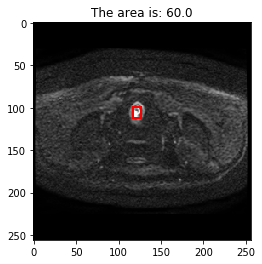

In [11]:
# run some demo
i=int(choice(len(train_files),1))
demo(train_dict,i)

In [12]:
# validation set
val_dict=coco_dict_gen(val_files,imgFile,mskFile)
with open('validation.json','w') as f:
    print('Saving the validation set...')
    json.dump(val_dict,f)
    print('Complete!')

100%|██████████| 84/84 [00:00<00:00, 248.66it/s]

Saving the validation set...
Complete!


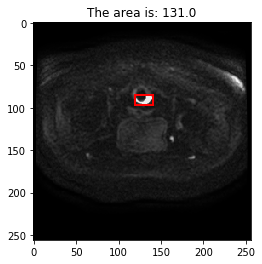

In [13]:
# run some demo
i=int(choice(len(val_files),1))
demo(val_dict,i)

In [14]:
# test set
test_dict=coco_dict_gen(test_files,imgFile,mskFile)
with open('test.json','w') as f:
    print('Saving the test set...')
    json.dump(test_dict,f)
    print('Complete!')

100%|██████████| 84/84 [00:00<00:00, 296.34it/s]

Saving the test set...
Complete!


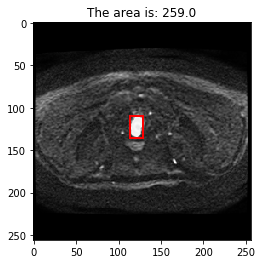

In [15]:
# run some demo
i=int(choice(len(test_files),1))
demo(test_dict,i)

In [16]:
coco=COCO('./train.json')
imgIds=coco.getImgIds()
imgsInfo=coco.loadImgs(imgIds)

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


In [17]:
mask_utils.frPyObjects(coco.loadAnns(1)[0]['segmentation'],256,256)

[{'size': [256, 256],
  'counts': b'SSn01l73VHMd754O_HMW72kH0Q7ORI1m6OTI0l60TI0l60TI0m6OSI0n61PI0Q7OoH0S7Oa00m\\n0'}]

In [18]:
print(coco.getCatIds())

[1]


In [19]:
# compute pixel mean and largest height and width on training data
pix_mean=[]
hws=[]
for imgInfo in tqdm(imgsInfo):
    hws.append([imgInfo['height'],imgInfo['width']])
    image=plt.imread(imgInfo['file_name'],'RGB')[:,:,:3]
    pix_mean.append(np.mean(image,axis=(0,1)))
np.max(hws,0),np.min(hws,0),np.mean(pix_mean,0)[::-1]

100%|██████████| 3175/3175 [00:11<00:00, 267.44it/s]


(array([256, 256]),
 array([256, 256]),
 array([28.9744663, 28.9744663, 28.9744663]))

In [20]:
# similar on the test set
h_lst=[]
w_lst=[]
for i in tqdm(range(len(test_files))):
    file=test_files[i]
    image_dir=imgFile+file
    # load the image
    image=plt.imread(image_dir,'RGB')[:,:,:3]
    h_lst.append(image.shape[0])
    w_lst.append(image.shape[1])
np.max(h_lst),np.min(h_lst),np.max(w_lst),np.min(w_lst)

100%|██████████| 84/84 [00:00<00:00, 401.11it/s]


(256, 256, 256, 256)